# Scenario 1: All modalities exists, no heterginity

In [1]:
import os
import torch
import torch.cuda as cuda
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision.transforms as transf
from torchsummary import summary
import numpy as np
import pandas as pd

from data_feed import DataFeed, DataFeed_image_pos
from build_net import resnet50, NN_beam_pred, MultinomialLogisticRegression
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
batch_size = 64
val_batch_size = 1
lr = 1e-3
decay = 1e-4
num_epochs = 20
train_size = [1]
no_users = 20

In [3]:
########################################################################
########################### Data pre-processing ########################
########################################################################


img_resize = transf.Resize((224, 224))
img_norm = transf.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
proc_pipe = transf.Compose(
    [transf.ToPILImage(),
     img_resize,
     transf.ToTensor(),
     img_norm]
)
dataset_dir = "feature_IID/"
train_loaders = []
test_loaders = []
val_loaders = []

for user_id in range(no_users):
    train_dir = dataset_dir + f'user_{user_id}_pos_height_beam_train.csv'
    val_dir = dataset_dir + f'user_{user_id}_pos_height_beam_val.csv'
    test_dir = dataset_dir + f'user_{user_id}_pos_height_beam_test.csv'
    
    train_dataset = DataFeed_image_pos(train_dir, transform=proc_pipe)
    val_dataset = DataFeed_image_pos(root_dir=val_dir, transform=proc_pipe)
    test_dataset = DataFeed_image_pos(root_dir=test_dir, transform=proc_pipe)
    
    
    train_loaders.append(DataLoader(train_dataset,
                              batch_size=batch_size,
                              #num_workers=8,
                              shuffle=False))
    val_loaders.append(DataLoader(val_dataset,
                            batch_size=val_batch_size,
                            #num_workers=8,
                            shuffle=False))
    test_loaders.append(DataLoader(test_dataset,
                            batch_size=val_batch_size,
                            #num_workers=8,
                            shuffle=False))
    print(f"Loaded_user: {user_id}")

Loaded_user: 0
Loaded_user: 1
Loaded_user: 2
Loaded_user: 3
Loaded_user: 4
Loaded_user: 5
Loaded_user: 6
Loaded_user: 7
Loaded_user: 8
Loaded_user: 9
Loaded_user: 10
Loaded_user: 11
Loaded_user: 12
Loaded_user: 13
Loaded_user: 14
Loaded_user: 15
Loaded_user: 16
Loaded_user: 17
Loaded_user: 18
Loaded_user: 19


In [4]:
for _, (x, y) in zip(range(1), train_loaders[0]):
    print(x["pos_height"].shape)

torch.Size([64, 4])


In [14]:
# Model Preperation#
all_models = []
available_modalities = ["pos_height", "images"]
user_modalities = [available_modalities for _ in range(no_users)]
modality_size = {"pos_height": 512, "images": 2048}
output_sizes = [sum([modality_size[i] for i in user_modality]) for user_modality in user_modalities]

local_classifiers = [MultinomialLogisticRegression(output_sizes[i], 64) for i in range(no_users)]
for user_id in range(no_users):
    user_model = {}
    if "images" in user_modalities[user_id]:
        user_model["images"] = resnet50(pretrained=True, progress=True, num_classes=64)
    if "pos_height" in user_modalities[user_id]:
        user_model["pos_height"] = NN_beam_pred(num_features=4, num_output=64)
    all_models.append(user_model)
    

Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottle

In [15]:
local_classifiers[0]

MultinomialLogisticRegression(
  (linear): Linear(in_features=2560, out_features=64, bias=True)
)

In [9]:
# Create a connected random topology using NetworkX
def create_random_topology(num_users=no_users, edge_probability=0.3, modalities=user_modalities):
    """
    Creates a connected random topology using NetworkX.
    Returns the adjacency matrix and mixing matrix.
    """
    while True:
        graph = nx.erdos_renyi_graph(num_users, edge_probability)
        if nx.is_connected(graph):
            break

    # Plot the graph (optional)
    #nx.draw(graph, with_labels=True, node_color="lightblue", font_weight="bold")
    #plt.title("Random Connected Topology")
    #plt.show()

    # Convert graph to adjacency matrix
    adjacency_matrix = nx.to_numpy_array(graph)

    # Create mixing matrix (row stochastic)
    mixing_matrix = adjacency_matrix / adjacency_matrix.sum(axis=1, keepdims=True)
    return adjacency_matrix, mixing_matrix

# Decentralized aggregation function
def decentralized_aggregation(user_models, mixing_matrix):
    """
    Aggregates user models based on the mixing matrix.
    """
    num_users = len(user_models)
    aggregated_models = [t.nn.utils.parameters_to_vector(user_model.parameters()) for user_model in user_models]
    aggregated_updates = [t.zeros_like(aggregated_models[0]) for _ in range(num_users)]

    for i in range(num_users):
        for j in range(num_users):
            if mixing_matrix[i, j] > 0:
                aggregated_updates[i] += mixing_matrix[i, j] * aggregated_models[j]

    # Update user models with aggregated parameters
    for i in range(num_users):
        t.nn.utils.vector_to_parameters(aggregated_updates[i], user_models[i].parameters())

def train_local_model(local_modalities, models, train_loader, criterion, optimizers, epochs):

    for modality in local_modalities:
        print(f"Training for modality: {modality}")
        
        model = models[modality]
        optimizer = optimizers[modality]
        
        model.train()
        for epoch in range(epochs):
            for data, labels in train_loader:
                # Move data to GPU if available
                data = data[modality]
                data, labels = data, labels#data.cuda(), labels.cuda()
                
                # Zero the gradients
                optimizer.zero_grad()
                
                # Forward pass
                temp, outputs = model(data)

                if modality == "images":
                    print(temp.shape)
                
                # Compute loss
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
                
                # Optional: Print loss for debugging
                print(f"Epoch [{epoch + 1}/{epochs}], Modality: {modality}, Loss: {loss.item():.4f}")
    
    return models



In [16]:
def validate_user_models(user_id, user_models, val_loaders, criterion):

    print(f"Validating model for User {user_id + 1}")


    with torch.no_grad():  # Disable gradient computation for validation
        for modality, model in user_models.items():
            total_loss = 0.0
            total_correct = 0
            total_samples = 0
            model.eval()
            if modality not in user_models.keys():
                print(f"Skipping modality {modality} for User {user_id + 1}, no validation data.")
                continue
            
            for data, labels in val_loaders:  # Iterate over validation data for the modality
                data = data[modality]
                data, labels = data.cuda(), labels.cuda()

                # Forward pass
                _, outputs = model(data)
                loss = criterion(outputs, labels)

                # Accumulate loss and accuracy
                total_loss += loss.item() * labels.size(0)  # Sum loss for the batch
                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)

            # Compute metrics
            avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
            accuracy = total_correct / total_samples if total_samples > 0 else 0.0
        
            print(f"User {user_id + 1}, modality: {modality} - Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        return {'loss': avg_loss, 'accuracy': accuracy}


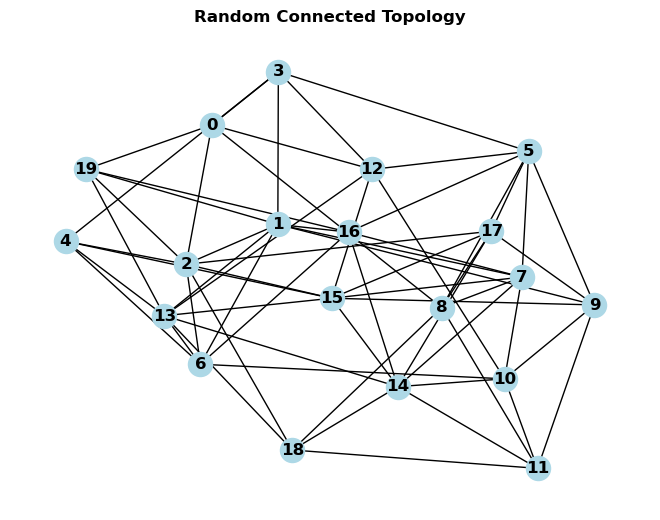

Global Round 1
Training image modalitity models
Training model for User 1
Training for modality: pos_height
Epoch [1/1], Modality: pos_height, Loss: 3.1062
Epoch [1/1], Modality: pos_height, Loss: 3.0135
Epoch [1/1], Modality: pos_height, Loss: 2.7817
Epoch [1/1], Modality: pos_height, Loss: 2.8905
Epoch [1/1], Modality: pos_height, Loss: 3.3052
Epoch [1/1], Modality: pos_height, Loss: 3.2222
Epoch [1/1], Modality: pos_height, Loss: 2.4947
Epoch [1/1], Modality: pos_height, Loss: 2.5907
Epoch [1/1], Modality: pos_height, Loss: 2.9945
Epoch [1/1], Modality: pos_height, Loss: 2.7064
Epoch [1/1], Modality: pos_height, Loss: 2.5736
Epoch [1/1], Modality: pos_height, Loss: 2.9361
Epoch [1/1], Modality: pos_height, Loss: 2.6119
Epoch [1/1], Modality: pos_height, Loss: 2.6653
Epoch [1/1], Modality: pos_height, Loss: 2.5449
Epoch [1/1], Modality: pos_height, Loss: 2.8631
Epoch [1/1], Modality: pos_height, Loss: 2.8674
Epoch [1/1], Modality: pos_height, Loss: 2.7923
Epoch [1/1], Modality: pos_h

KeyboardInterrupt: 

In [10]:
# Create random connected topology and mixing matrix
adjacency_matrix, mixing_matrix = create_random_topology(no_users, edge_probability=0.3)
local_epochs = 1
global_rounds = 10
weight_decay = 1e-5
criterion = nn.CrossEntropyLoss()
val_losses = []
# Decentralized Training
for round_num in range(global_rounds):
    print(f"Global Round {round_num + 1}")

    # Training for image_modalities 
    print("Training image modalitity models")
    # Train each user's local model
    for user_id in range(1):
        print(f"Training model for User {user_id + 1}")
        user_models = all_models[user_id]
        optimizers = {}
        for modality in user_model.keys():
            optimizers[modality] = optim.Adam(user_models[modality].parameters(), lr=lr, weight_decay=weight_decay)
        train_local_model(user_modalities[user_id], user_models, train_loaders[user_id], criterion, optimizers, local_epochs)

    # Decentralized aggregation
    print("Performing decentralized aggregation")
    #decentralized_aggregation(user_models, mixing_matrix)

    # Optionally, validate models
    print("Validating user models...")
    for user_id in range(no_users):
        user_models = all_models[user_id]
        val_dict = validate_user_models(user_id, user_models, val_loaders[user_id], criterion)
        val_losses.append(val_dict)


print("Decentralized federated learning complete.")

In [31]:
model = all_models[0]["images"]
optimizer = optim.Adam(user_models["images"].parameters(), lr=lr, weight_decay=weight_decay)
for data, labels in train_loaders[0]:
    # Move data to GPU if available
    data = data["images"]
    data, labels = data, labels#data.cuda(), labels.cuda()
    
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    _, outputs = model(data)
    print(outputs[1].shape)

torch.Size([64, 64])
torch.Size([64, 64])


KeyboardInterrupt: 